In [1]:
import os
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
import dataset_lvis
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt

In [125]:
importlib.reload(dataset_lvis)

<module 'dataset_lvis' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/dataset_lvis.py'>

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

pick an easier problem:
<br> sofa	414	528	f
<br> signboard	398	1799	


https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [127]:
data_args = {'stage': 'val',
            'classes': ['signboard'], #['sofa', 'signboard'],
            'ds_path' : "/home/Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images'}
val_data = dataset_lvis.LVISData(**data_args)

Loaded 86 images!
354 annotations found!
stage:  val
classes:  {'signboard': 959}
ds_path:  /home/Datasets/coco/
labels_f:  /home/Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  /home/Datasets/coco/images/val2017


# Fine-tuning the model

In [128]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [129]:
class CollateCustom:
    
    def __init__(self, batch_first=True):
        #self.pad_val = pad_value
        self.batch_first = batch_first
    
    def __call__(self, batch):
        
        idxs = [item[0] for item in batch]
        
        X = [item[1].unsqueeze(0) for item in batch]
        X = torch.cat(X, dim = 0)
        
        y = [item[2] for item in batch]
        #y = pad_sequence(y, batch_first=self.batch_first, padding_value=self.pad_val)
        
        return idxs, X, y
    

In [130]:
#Split dataset to test and train
indices = torch.randperm(len(val_data)).tolist()


dataset_train = torch.utils.data.Subset(val_data, indices[:80])
dataset_test = torch.utils.data.Subset(val_data, indices[80:])


train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=CollateCustom())


test_loader = torch.utils.data.DataLoader(
 dataset_test, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=CollateCustom())



In [7]:
len(train_loader)

80

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [11]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 


num_epochs = 10
time_start = time.time() 


loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
#batch_loss = 0 

for epoch in range(num_epochs):
    model.train()
    
    #reset loss 
    batch_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_mask = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    
    
    
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        #save losses 
        loss_classifier += loss_dict['loss_classifier'].item()
        loss_box_reg += loss_dict['loss_box_reg'].item()
        loss_mask += loss_dict['loss_mask'].item()
        loss_objectness += loss_dict['loss_objectness'].item()
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item() 
        
        losses = sum(loss for loss in loss_dict.values())
        batch_loss  += losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    avg_batch_loss = batch_loss/(batch_num + 1) 
    
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [loss_classifier/(batch_num+1)],
          'loss_box_reg' : [loss_box_reg/(batch_num+1)],
           'loss_mask': [loss_mask/(batch_num+1)],
           'loss_objectness': [loss_objectness/(batch_num+1)],
           'loss_rpn_box_reg': [loss_rpn_box_reg/(batch_num+1)],
            'total_loss': avg_batch_loss 
          })     

    loss_df = pd.concat([loss_df, row], ignore_index = True, axis = 0)
    

    print(f"Loss after {epoch} epochs: {avg_batch_loss}")
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")
        
        
        
        


Loss after 0 epochs: 1.1554785791784525
Loss after 1 epochs: 0.8425614412873983
Loss after 2 epochs: 0.667971876449883
Loss after 3 epochs: 0.584897343069315
Loss after 4 epochs: 0.508697060495615
Loss after 5 epochs: 0.421296329330653
Loss after 6 epochs: 0.36439209096133707
Loss after 7 epochs: 0.31702438136562705
Loss after 8 epochs: 0.2750205178745091
Loss after 9 epochs: 0.2506897195242345
Time elapsed for 10 epochs: 2.27 min


In [12]:
loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.154571,0.117257,0.615342,0.214013,0.054296,1.155479
1,1,0.150801,0.141826,0.393145,0.100264,0.056525,0.842561
2,2,0.142383,0.14353,0.29192,0.047409,0.042731,0.667972
3,3,0.120617,0.121564,0.27223,0.033781,0.036705,0.584897
4,4,0.100871,0.119922,0.224941,0.027784,0.035179,0.508697
5,5,0.082018,0.11715,0.169971,0.016915,0.035243,0.421296
6,6,0.069628,0.110251,0.149106,0.009645,0.025761,0.364392
7,7,0.052398,0.097563,0.129336,0.007425,0.030302,0.317024
8,8,0.042141,0.08687,0.118542,0.005059,0.022409,0.275021
9,9,0.037303,0.079399,0.11305,0.00372,0.017218,0.25069


# Plot loss 

<AxesSubplot:xlabel='epoch', ylabel='total_loss'>

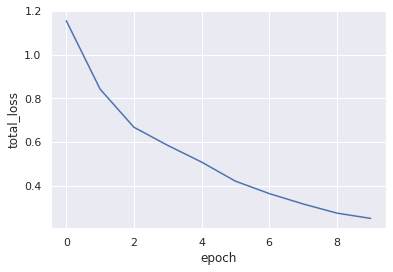

In [30]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

sns.lineplot(data=loss_df, x="epoch", y="total_loss")


# Test cases

46


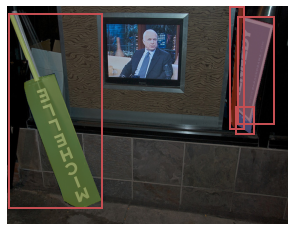

In [131]:
idx, X, y = next(iter(test_loader))
model.eval() 
None
print(idx[0])

#val_data.plot_img(idx[0])
val_data.plot_img_with_ann(idx[0], bboxes = True)

In [132]:
y_pred = model(X.to(device))
y_pred

[{'boxes': tensor([[524.5190,  18.4123, 607.0182, 268.1865],
          [  3.4399,  12.7666, 220.1588, 477.5783],
          [510.6415,   3.0236, 540.3976, 271.0909],
          [522.7360, 229.1522, 563.3812, 291.2697],
          [ 17.1481,  89.9310, 192.4368, 364.2745],
          [215.5050,  28.8240, 407.3849, 183.4227]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9867, 0.9866, 0.9792, 0.9604, 0.1016, 0.0520], device='cuda:0',
         grad_fn=<IndexBackward0>),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,

(640, 496)


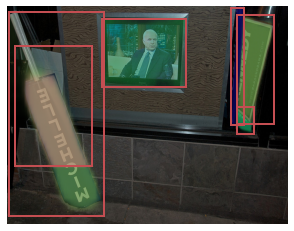

In [133]:
plot_predictions(idx[0], y_pred)